<div style="background-color:lightblue; width:100%; height:500px; color:black; text-align:center;"><br>
  <div style="font-size:24px; font-weight:bold; text-align:center;">2023 IACV Project: Tracking Volley Ball</div><br>
  <div style="font-size:18px; font-weight:bold; text-align:center;">By Lynda Attouche</div><br>

  <div style="margin-top:0; text-align:center; font-size:16px;">
    This is a computer vision project that aims to track a ball during a volleyball game and retrieve the trajectory. It consists of 2 notebooks and a python script:
  </div>

  <ul style="list-style-type: none; text-align:center;">
    <li>Tracking Ball (lambda trajectory).ipynb</li>
    <li>Tracking Ball (parabolic trajectory).ipynb</li>
    <li>KalmanFilter.py</li>
  </ul>

  <span style="display:inline-block; margin-top:20px;">
    <img src="https://i.postimg.cc/NMtSpqp9/fdd73961df5344d031c360e49fa7244a-poland-photography.jpg" alt="An image of Poland" style="width:150px; height:150px; border-radius:50%;">
  </span>

  <div style="margin-top:20px; text-align:center;">
    <div style="font-size:15px; font-weight:bold;">This following notebook is dealing with a video containing a none-specific ball trajectory!</div>
  </div>
</div>


 Table of Contents

1. [Imports](#section-1)
2. [Ball Detection & Tracking (2D)](#section-2)
3. [2D Trajectory](#section-3)
4. [Trajectory reconstruction 3D](#section-3)


# Imports # 

In [10]:
import sys
import cv2
import math
import re
import numpy as np
import matplotlib.pyplot as plt
import os
from KalmanFilter import KalmanFilter #from python script

In [91]:
dir_videos = r'C:\Users\Lynda\Documents\Volley Ball Tracking/Videos/'
dir_files = r'C:\Users\Lynda\Documents\Volley Ball Tracking/Data_points/'

video = dir_videos +"vid2.mp4"

# Ball Detection & Tracking (2D) #

In [23]:
# Open the video file using OpenCV's VideoCapture function
cap = cv2.VideoCapture(video)

# Get the first frame as reference
ret, prev = cap.read()

# Resize the first frame to 1300x500 (not mondatory only for laptop 13") and convert it to grayscale
prev_gray = cv2.resize(cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY),(1300,500))

# Create a structuring element in the shape of an ellipse with a size of (5, 5)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)) 

# Create a background subtractor using the MOG2 method
fgbg =cv2.createBackgroundSubtractorMOG2() 

# Create a list to store ball
ball = []

# Define the motion model
warp_mode = cv2.MOTION_HOMOGRAPHY
 
# Set the termination criteria for the optical flow algorithm
termination_criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1e-3)

# Initialize the connected components (cc) and warp matrix (warp_matrix) to None
cc, warp_matrix = None,None

# Initialize a tuple 'tmp' with values (0,0)
tmp = (0,0)


# Read the video frame by frame
while 1:
    # Capture the current frame
    ret, frame = cap.read()
    
    # If the video has ended, break the loop
    if not ret:
        break
    
    # Resize the frame to 1300x500 pixels
    f = cv2.resize(frame,(1300,500))
    
    # Also resize the original frame to 1300x500 pixels
    frame = cv2.resize(frame,(1300,500))

    
    # 1. Frame Processing
    # Convert the current frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Perform histogram equalization on the grayscale frame
    frame_gray = cv2.equalizeHist(gray)

    # Compute the enhanced correlation coefficient transform between the previous and current grayscale frames
    (cc, warp_matrix) = cv2.findTransformECC(prev_gray, gray, warp_matrix, warp_mode, termination_criteria)

    # Get the height and width of the frame
    height, width = frame.shape[:2]
    
    # Use the warpPerspective function to stabilize the frame
    stabilized = cv2.warpPerspective(frame, warp_matrix, (width, height), flags=cv2.INTER_CUBIC + cv2.WARP_INVERSE_MAP)
    
    # Convert the stabilized frame to grayscale
    frame = cv2.cvtColor(stabilized , cv2.COLOR_BGR2GRAY)
    
    # Apply background subtraction to the grayscale frame
    fgmask = fgbg.apply(frame)
    
    # Perform morphological opening on the resulting mask
    fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)    

    # Apply Canny edge detection on the foreground mask
    e = cv2.Canny(fgmask, 50, 190, 3)
    
    # Threshold the image to keep only edges (value 0 to 127 will be set to 0 and values 128 to 255 will be set to 255)
    _, fgmask = cv2.threshold(e, 127, 255, 0)

    #cv2.imshow('mask',fgmask)
    
    
    
    # 2. Ball detection using filtering techniques

    # Find contours in the binary image "fgmask"
    contours, _ = cv2.findContours(fgmask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
   

    # Define a variable that will contain a possible candidate ball
    candidate_accepted = None
    
    # Update previous frame
    prev_gray = frame_gray
    
    
    # Loop over contours
    for contour in contours:
        
        # Extract the bounding rectangle coordinates (x, y) of the top-left corner and the width (w) and height (h) of the rectangle surrounding a contour
        (x, y, w, h) = cv2.boundingRect(contour)
        
        # Compute the area of the contour
        area = cv2.contourArea(contour) 
        
        # Compute perimeter of the contour
        perimeter = cv2.arcLength(contour, True)  
        
        # Define variable for circularity
        circularity = 0
        
        # i. Circular shape filter: detect circular blobs
        
        # Check if the perimeter is not null
        if perimeter !=0:
            
            # Calculate circularity of the contour
            circularity = 4 *math.pi* area/ perimeter**2
            
            # Check if the contour has a circularity between 0.3 and 0.8. Circularity is a measure of how close the contour shape is to a circle
            if circularity >=0.3 and circularity <=0.8: 
                candidate_accepted =  contour

        # ii. Elliptical shape filter: detect elliptical blobs 

        # Check whether the width of the blob is not null
        elif w!=0:
        
            # Calculate eccentricity of the contour
            eccentricity = h/w
            
            # Check if the shape of the contour has a circularity value between 0 and 0.7, to get elliptical ball
            if eccentricity>0 and eccentricity <=0.7:
                candidate_accepted =  contour

        # iii. Size filter: allows removing small blobs
        
        # Check if the contour area is within the specified range (20 to 60)
        if  area<60 and area>20: 
            candidate_accepted =  None 
   
    if candidate_accepted is not None: 
        
        # Get the minimum enclosing circle for the candidate object
        (x, y), radius = cv2.minEnclosingCircle(candidate_accepted)
        
        # Keep track of the ball in current frame
        tmp = (x,y)
        
        # Add the coordinate of the detected ball to the list
        ball.append(np.array([[x], [y]]))
        
        # Draw a circle with center at (x,y) and radius 20 in the image f using BGR color (155,200,95) and line width 2
        cv2.circle(f, (int(x),int(y)), 20, (155,200,95), 2)

    # Display the current frame
    cv2.imshow('frame',f)  
    
    # Control loop, if 'q' pressed, breaks it
    if cv2.waitKey(10) == ord("q"): 
        break


# Release the video capture
cap.release()

# Destroy all open windows.
cv2.destroyAllWindows()

In [29]:
print("Number of ball locations found is: ", len(ball))
cap = cv2.VideoCapture(video)
print("Number of frame of the video is: ", int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))

Number of ball locations found is:  68
Number of frame of the video is:  1022


# 2D Trajectory  #

Text(0.5, 0.98, 'Trajectories of the ball wrt to x,y direction independently')

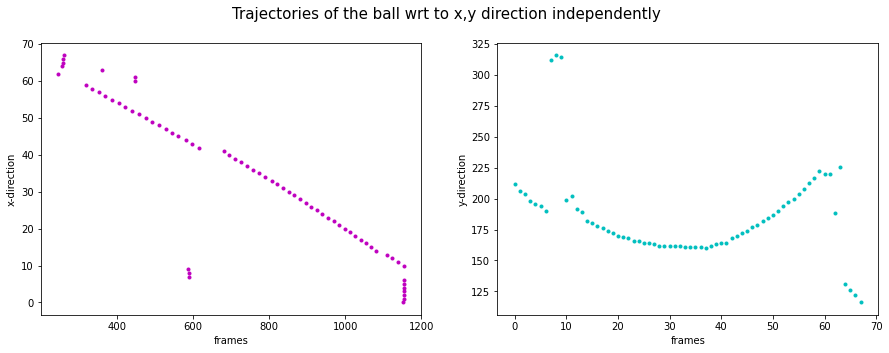

In [76]:
# Define an array of rounded x-coordinates of the ball, obtained from the ball list previously found
x_dim = np.array([round(ball[i][0][0]) for i in range(len(ball))])

# Define an array of rounded y-coordinates of the ball, obtained from the ball list previously found
y_dim = np.array([round(ball[i][1][0]) for i in range(len(ball))])

# Define an array of the frame number where the ball has been detected
frames_det = np.arange(len(ball))

# Create a figure and axis object using subplots
fig,ax = plt.subplots(1,2,figsize=(15,5))

# Plot the data points from fr_dim and x_dim on the first axis (index 0)
ax[0].plot(x_dim,frames_det, '.', color='m')

# Plot the data points from fr_dim and y_dim on the second axis (index 1)
ax[1].plot(frames_det, y_dim, '.', color='c')

# Set the x-label for the first axis to "frames"
ax[0].set_xlabel('frames')

# Set the y-label for the first axis to "x-direction"
ax[0].set_ylabel('x-direction')

# Set the x-label for the second axis to "frames"
ax[1].set_xlabel('frames')

# Set the y-label for the second axis to "y-direction"
ax[1].set_ylabel('y-direction')

# Add a title to the figure using suptitle
fig.suptitle('Trajectories of the ball wrt to x,y direction independently', fontsize=15)

In [85]:
#Apply Kalman to estimate the location of the object (to keep tracking of the ball when it disappears)

# Initialize the KalmanFilter object with parameters
KF = KalmanFilter(0.1, 1, 1, 1, 0.1,0.1)

# Create an empty list to store the updates
updates = []

# Loop through each blob in the list of blobs
for i in range(len(ball)):
    
    # Get the 2D point for the blob in this frame
    measurement = ball[i]

    # Predict step
    (x, y) = KF.predict()

    # Update step
    (x1, y1) = KF.update(measurement)
    
    # Convert the resulting x1 and y1 from numpy arrays to floats and append to updates
    updates.append([np.array(x1)[0][0],np.array(y1)[0][0]])

Text(0.5, 0.98, 'Trajectories of the ball wrt to x,y direction independently')

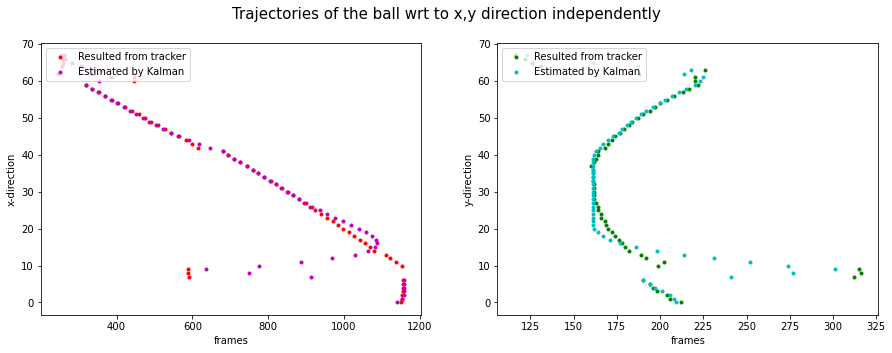

In [86]:
# Create arrays for the predicted x and y positions, and the frames of the candidates blobs
tracked_positions = np.array(updates)

# Create an array of the predicted x positions
x_estim = np.array([round(tracked_positions[i][0]) for i in range(len(tracked_positions))])

# Create an array of the predicted y positions
y_estim = np.array([round(tracked_positions[i][1]) for i in range(len(tracked_positions))])

# Create an array of the frames
frames = np.arange(len(tracked_positions))

# Create a figure with 1 row and 2 columns of subplots
fig, ax = plt.subplots(1, 2, figsize=(15,5))

# Plot the predicted x-direction and y-direction trajectory of the candidates blobs
ax[0].plot( x_dim,frames, '.', color='r', label = 'Resulted from tracker')
ax[0].plot( x_estim, frames,'.', color='m',label = "Estimated by Kalman")

ax[1].plot( y_dim, frames,'.', color='g', label = 'Resulted from tracker')
ax[1].plot(y_estim, frames,  '.', color='c', label = "Estimated by Kalman")

# Add labels for the x and y axis for both subplots
ax[0].set_xlabel('frames')
ax[0].set_ylabel('x-direction')
ax[1].set_xlabel('frames')
ax[1].set_ylabel('y-direction')

# Add legends
ax[0].legend(loc="upper left")
ax[1].legend(loc="upper left")

# Add a title to the figure
fig.suptitle('Trajectories of the ball wrt to x,y direction independently', fontsize=15)


Text(0, 0.5, 'y_dim')

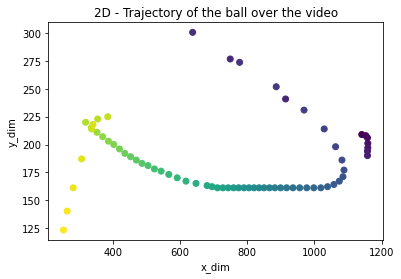

In [87]:
plt.scatter(x_estim, y_estim, c=range(len(x_estim)))
plt.title("2D - Trajectory of the ball over the video")
plt.xlabel("x_dim")
plt.ylabel("y_dim")

In [88]:
# Stack the x and y dimensions of found and estimated into separate arrays
found = np.stack([x_dim, y_dim], axis=1)
estimated = np.stack([x_estim, y_estim], axis=1)

# Save the found and estimated arrays as tab-delimited text files
np.savetxt(dir_files+"balls_detected.txt", found, delimiter="\t", header="x\y", comments='')
np.savetxt(dir_files+"balls_estimated.txt", estimated, delimiter="\t", header="x\y", comments='')


# Trajectory reconstruction 3D #

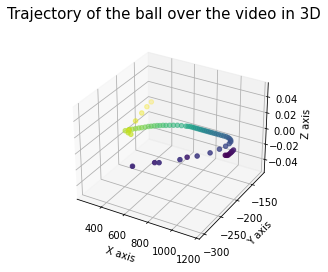

In [90]:
# Assume z is fixed, I kindly invite you to read my report :) to get the reason why
z = np.zeros(len(x_dim))

# Create a 3D plot using the projection argument
fig,ax  = plt.figure(), plt.axes(projection='3d')
fig.suptitle("Trajectory of the ball over the video in 3D", fontsize=15)

# plot the 3D scatter plot
ax.scatter(x_estim,- y_estim, z, c = range(len(x_dim)))

# set x, y, and z labels
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

plt.show()
